<a href="https://colab.research.google.com/github/dirksen/ml-playground/blob/main/Digging_For_Good_Debates_using_DeBERTa_Large_model_from_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debate Mining

When watching Youtube vidoes on hot-button topics, I would often deep dive into the comments section to look for good arguments and counter arguments. Youtube organize the comments section into two levels: top level comments that address to the video, and replies to those comments. Often I found good debates among these reply threads that brought fresh angles and insights. Unfortunately, Youtube's UI make it very difficult to dig up good debates:
1. Youtube doesn't sort comments by the number of replies. I have to scroll and skip a lot of comments of zero replies just to access the reply threads.
2. Not all threads present good debates. Many of them are one-sided, like mini-echo-chambers. It's time consuming to read tens of replies only to find out there isn't much debate going in the thread.

This notebook attempts to mine good debates from the video comment threads, by using Youtube API to scrape top N most replied comment threads, and then use ChatGPT API to rank them. It will render the threads at the end for easy reading.

First, let's install all the dependencies:

In [ ]:
!pip install torch pandas google-api-python-client transformers ipdb
# !pip install --pre torch --extra-index-url https://download.pytorch.org/whl/nightly/cpu

import ipdb
# from google.colab import drive, data_table
# from IPython.display import HTML, display
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import googleapiclient.discovery
from transformers import pipeline


We need API keys to access Youtube API:

In [ ]:
# DEVELOPER_KEY = os.getenv('DEVELOPER_KEY')
from google.colab import userdata
DEVELOPER_KEY = userdata.get('DEVELOPER_KEY')

`TARGET_VIDEO_ID` is the video we want to mine debates from (you can watch the video [here](https://www.youtube.com/watch?v=5-rhLH5lYi4)):

In [ ]:
# Change TARGET_VIDEO_ID to your liking
TARGET_VIDEO_ID = 'F5AQyWAWHU4'
print(f'Video can be visited here: https://www.youtube.com/watch?v={TARGET_VIDEO_ID}')


Video can be visited here: https://www.youtube.com/watch?v=F5AQyWAWHU4


Scrape all top level comments and get a count of replies of each. Note Youtube chunks the comments by pages. The generator method `pageFlipper` helps going through all the pages of comments:

In [ ]:

api_service_name = "youtube"
api_version = "v3"

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey = DEVELOPER_KEY)

def pageFlipper(func, **kwargs):
  nextPageToken = None
  while True:
    kwargs['pageToken'] = nextPageToken
    request = func(**kwargs)
    response = request.execute()
    yield response
    # last page
    if 'nextPageToken' not in response:
      break
    nextPageToken=response['nextPageToken']

paginatedResults = pageFlipper(youtube.commentThreads().list,
    videoId=TARGET_VIDEO_ID,
    textFormat='plainText',
    part='snippet',
  )

extract = lambda comment: dict(
      id=comment['id'],
      replies=comment['snippet']['totalReplyCount'],
      author=comment['snippet']['topLevelComment']['snippet']['authorDisplayName'],
      publishedAt=comment['snippet']['topLevelComment']['snippet']['publishedAt'],
      text=comment['snippet']['topLevelComment']['snippet']['textOriginal'],
)

entries = [extract(comment) for page in paginatedResults for comment in page['items']]
top_comments_df = pd.DataFrame(entries).set_index(['id'])


Take the top N most replied comments (N is a measurement of the depth of your pocket, i.e. the larger the N the higher the cost of running ChatGPT).

In [ ]:
# %pdb on
N = 100
selected_top_comments_df = top_comments_df.sort_values(['replies']).tail(N)
selected_top_comments_df



,replies,author,publishedAt,text
id,,,,
Ugxut21Sq55rUCWclfR4AaABAg,11,@hutgarveyiteofthemic9763,2019-06-28T02:21:23Z,I agree with reparations for moral standpoint ...
Ugzlu1EQOh-JTMCeoKF4AaABAg,11,@rmbuilders9448,2019-12-15T21:01:30Z,It’s pathetic to say if you don’t agree with m...
UgxrX_ZSczkLsZT0frZ4AaABAg,11,@Chipadychuck,2020-06-07T22:57:06Z,"Not to distract from the content, but the blon..."
UgxqNPPUJMTjaLitqUR4AaABAg,11,@valencia4215,2019-06-21T03:23:54Z,I am embarrassed by this hearing because Coate...
UgwUjcSsrO9grrAwkKB4AaABAg,11,@justinz9225,2020-06-10T21:19:42Z,"""There's TOTALLY a connection."" I can't prove ..."
...,...,...,...,...
UgwvQSkVtdt4vb_x2aN4AaABAg,139,@jonathanrodriguez9232,2020-06-07T20:46:04Z,80% of that room is having a hard time swallow...
UgwZFCTh05EMYOYZzjJ4AaABAg,190,@TStantonMiami,2020-06-13T12:52:44Z,I’m a black woman. Descendant of slaves and I ...
UgzwWmxO96mp0TcxBUB4AaABAg,193,@TenTonNuke,2020-09-23T13:15:55Z,The fact that people would boo at 10:20 after ...


Download replies for each top comments (the replies are also paginated, hence the usage of `pageFlipper` again):

In [ ]:
replies = []
for top_comment_id, _ in selected_top_comments_df.iterrows():
  paginatedResults = pageFlipper(youtube.comments().list,
      parentId=top_comment_id,
      textFormat='plainText',
      part='snippet',
    )
  for comment in [comment for page in paginatedResults for comment in page['items']]:
    entry = dict(
        id= comment['id'],
        parent=top_comment_id,
        parent_text=_.text,
        replies='',
        author= comment['snippet']['authorDisplayName'],
        publishedAt= comment['snippet']['publishedAt'],
        reply_text= comment['snippet']['textOriginal'],
    )
    replies.append(entry)

replies_df = pd.DataFrame(replies).set_index('id').sort_values(['parent_text', 'publishedAt'])
replies_df

,parent,parent_text,replies,author,publishedAt,reply_text
id,,,,,,
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99eQLerygBX,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",,@bensmith8240,2020-06-08T19:39:30Z,Yea. Too much Sowell and Williams. Don't get ...
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99h5Q7hM_Wj,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",,@rbarnes4076,2020-06-09T20:34:20Z,@@bensmith8240 \n\nYou are thinking about this...
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99hGZHkP_Zs,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",,@dmonarredmonarre3076,2020-06-09T22:11:42Z,@@rbarnes4076 \nThis is pretty close to a perf...
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99mYKFQfz1c,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",,@rbarnes4076,2020-06-11T23:23:09Z,@@dmonarredmonarre3076 \nThanks! \n\nI've been...
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99mZGCZxeFg,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",,@dmonarredmonarre3076,2020-06-11T23:31:20Z,@@rbarnes4076 Rare to find such a well informe...
...,...,...,...,...,...,...
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59Ba1FGWcrzN,UgwpLGSQb30JceeGP814AaABAg,“He was presumptive but he still has the right...,,@bettybarrett323,2020-07-26T19:46:00Z,"Impartial ...no, no...not quite."
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59DfRNDTJXAV,UgwpLGSQb30JceeGP814AaABAg,“He was presumptive but he still has the right...,,@nalanigallaher7577,2020-09-16T15:13:16Z,Yeah WTF WAS THAT?!
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59En0B2f09fV,UgwpLGSQb30JceeGP814AaABAg,“He was presumptive but he still has the right...,,@samflintham1360,2020-10-14T10:21:00Z,"Yup, it undermined the whole setting. At least..."


Since we have the comment threads, we need to rank them. Based on observations, I found two indicators for a good debate:
1. Debate is like a tennis game: each side takes turn to present their arguments. The more rounds of back and forth, the more exciting the debate is.
2. A good debate should also be balanced, i.e. the number of pro arguments and con arguments should be close. A big delta between the two indicates the debate is one-sided.

Obviously, both indicators depend on the classification of each reply as either pro argument or con argument. This is where ChatGPT can help. I set up each top level comment as the target, and ask ChatGPT to classify the stance of each reply under that comment. Return 1 for pro argument, -1 for cons, and 0 for neutral.

To further save cost of running ChatGPT, here employs `functools.lru_cache` to cache the stance classification results, to avoid hitting ChatGPT for the same content twice:

In [ ]:
classifier = pipeline("zero-shot-classification", model='MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli', device = 0, batch_size = 1)


In [ ]:
# %pdb on
def detect_stance(claim, replies):
  statement = 'The author of this comment {} the claim: `%s`.' % claim
  labels = ['supports', 'opposes', 'does not express an opinion about']
  res = classifier(replies, labels, hypothesis_template = statement, multi_label = False)
  # per https://github.com/huggingface/transformers/issues/22387, reset the call_count to inhibit a warning
  classifier.call_count = 0
  df = pd.DataFrame()
  df['reply'] = replies
  df['stance'] = [label['labels'][0] for label in res]
  df['stance'].replace(regex = {r'supports':1, r'opposes':-1, r'does not express an opinion about': 0}, inplace = True)
  df['confidence'] = [label['scores'][0] for label in res]
  return df.stance.tolist()

df = replies_df.groupby(['parent_text']).agg(list).reset_index()
df

,parent_text,parent,replies,author,publishedAt,reply_text
0,"""Disparity is the norm, not the exception."" - ...","[UgyJ3iGvRzEGbt0Dlz54AaABAg, UgyJ3iGvRzEGbt0Dl...","[, , , , , , , , , , , , , , ]","[@bensmith8240, @rbarnes4076, @dmonarredmonarr...","[2020-06-08T19:39:30Z, 2020-06-09T20:34:20Z, 2...",[Yea. Too much Sowell and Williams. Don't get...
1,"""He was presumptive, but he has a right to spe...","[UgwYjVwxC-d4eeX9-Gd4AaABAg, UgwYjVwxC-d4eeX9-...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[@cmack17, @ChollieD, @512metro, @thiggs93, @u...","[2019-06-30T11:13:33Z, 2019-06-30T20:41:13Z, 2...","[Yes., And then the correct word is ""presumptu..."
2,"""He was presumptive, but he still had a right ...","[UgzsaUfKwpVsAfe5R-l4AaABAg, UgzsaUfKwpVsAfe5R...","[, , , , , , , , , , , , , , , , , , , ]","[@YoungO-un8ul, @oraz., @k.o.o.p.a., @rashimla...","[2020-10-14T04:56:14Z, 2020-10-14T19:56:40Z, 2...","[""chill"", That was so annoying. It's not that ..."
3,"""He was presumptive, but he still has a right ...","[UgxSSKCntOYaqvzfb194AaABAg, UgxSSKCntOYaqvzfb...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[@erikkovacs3097, @kyleholland9923, @dawnvierr...","[2020-06-12T03:11:24Z, 2020-06-12T03:17:06Z, 2...","[Chill chill chill chill yo!, What did he mean..."
4,"""None of these things [safer neighborhoods bet...","[Ugw5w2BslCrnknkIQnt4AaABAg, Ugw5w2BslCrnknkIQ...","[, , , , , , , , , , , , , ]","[@tamaraderouselle7133, @Uhdksurvhunter, @foxb...","[2020-07-09T04:08:21Z, 2020-07-13T19:06:53Z, 2...","[Brittany Roberts agreed, but as Mr. Coates po..."
...,...,...,...,...,...,...
95,You're either focused on the problem or you're...,"[Ugy1ngmPMRssiIDRwBV4AaABAg, Ugy1ngmPMRssiIDRw...","[, , , , , , , , , , , , , , , , , , , , , ]","[@stefanlangenhoven78, @Ezerlance, @beverlyf66...","[2020-06-11T21:50:00Z, 2020-06-12T03:51:44Z, 2...","[Why not both?, Stefan Langenhoven Focusing on..."
96,"i understand what Ta-Neshi tries to say, but t...","[UgzlvOyiK8sb8RL7m4Z4AaABAg, UgzlvOyiK8sb8RL7m...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[@michaeldoran4367, @elroco4827, @elroco4827, ...","[2020-06-05T23:53:17Z, 2020-06-06T00:19:33Z, 2...","[This is a great example of emotion vs logic, ..."
97,one speaks from a position of defeat and reven...,"[UgyFRcMqkUc09Vt0Ifd4AaABAg, UgyFRcMqkUc09Vt0I...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[@noeltaylor3594, @travisvinning6934, @WeGonBe...","[2019-12-08T16:10:09Z, 2019-12-12T19:59:46Z, 2...",[Really? You heard the stat about black median...
98,“Chill chill chill he was presumptive but he h...,"[UgxfrxPZKXUQnKjLH8t4AaABAg, UgxfrxPZKXUQnKjLH...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[@MrHabart, @TK-OK, @williamperry2379, @jamesw...","[2019-06-22T07:24:08Z, 2019-06-22T13:01:43Z, 2...",[That was a brutal interjection by Chairman Co...


In [ ]:
rslt = df.apply(lambda x: detect_stance(x.parent_text, x.reply_text), axis=1)
replies_df['stance'] = rslt.squeeze().explode().tolist()
replies_df


,parent,parent_text,replies,author,publishedAt,reply_text,stance
id,,,,,,,
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99eQLerygBX,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",,@bensmith8240,2020-06-08T19:39:30Z,Yea. Too much Sowell and Williams. Don't get ...,-1
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99h5Q7hM_Wj,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",,@rbarnes4076,2020-06-09T20:34:20Z,@@bensmith8240 \n\nYou are thinking about this...,0
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99hGZHkP_Zs,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",,@dmonarredmonarre3076,2020-06-09T22:11:42Z,@@rbarnes4076 \nThis is pretty close to a perf...,0
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99mYKFQfz1c,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",,@rbarnes4076,2020-06-11T23:23:09Z,@@dmonarredmonarre3076 \nThanks! \n\nI've been...,0
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99mZGCZxeFg,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",,@dmonarredmonarre3076,2020-06-11T23:31:20Z,@@rbarnes4076 Rare to find such a well informe...,0
...,...,...,...,...,...,...,...
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59Ba1FGWcrzN,UgwpLGSQb30JceeGP814AaABAg,“He was presumptive but he still has the right...,,@bettybarrett323,2020-07-26T19:46:00Z,"Impartial ...no, no...not quite.",-1
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59DfRNDTJXAV,UgwpLGSQb30JceeGP814AaABAg,“He was presumptive but he still has the right...,,@nalanigallaher7577,2020-09-16T15:13:16Z,Yeah WTF WAS THAT?!,1
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59En0B2f09fV,UgwpLGSQb30JceeGP814AaABAg,“He was presumptive but he still has the right...,,@samflintham1360,2020-10-14T10:21:00Z,"Yup, it undermined the whole setting. At least...",1


We can now count rounds of rallies for each thread. The counting goes on like this:
1. Drop neutral replies.
2. Collapse consequtive pros or cons into singles. E.g. [1, 1, 1, -1, -1, 1, 1] => [1, -1, 1]
3. The lengh of the result is the rounds of this debate thread.

Let's first drop the neutrals:

In [ ]:
# Sort replies under each top level comment (i.e. `parent`) by their timestamps
# Let's focus on the `parent` and `stance` columns:
stance_df = replies_df.sort_values(['parent_text', 'publishedAt'])[['parent', 'parent_text', 'reply_text', 'stance']]
# Drop neutral comments
stance_df = stance_df[(replies_df.stance != 0)]
stance_df


,parent,parent_text,reply_text,stance
id,,,,
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99eQLerygBX,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",Yea. Too much Sowell and Williams. Don't get ...,-1
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99o0ppQ-ZzG,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",Listening to Sowell recently. He's so based!,1
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99rLjFeg_2y,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",Your problem is that these “talking points” ar...,-1
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99rlMQ5EEus,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",@@dmonarredmonarre3076 \n\nAin't THAT the trut...,1
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99sHFWHpyfb,UgyJ3iGvRzEGbt0Dlz54AaABAg,"""Disparity is the norm, not the exception."" - ...",@@almcdonald8676 by that reasoning all of Sowe...,-1
...,...,...,...,...
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59BP4A3WVP-N,UgwpLGSQb30JceeGP814AaABAg,“He was presumptive but he still has the right...,@@maxjames2969 Good job with the nuanced break...,1
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59Ba1FGWcrzN,UgwpLGSQb30JceeGP814AaABAg,“He was presumptive but he still has the right...,"Impartial ...no, no...not quite.",-1
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59DfRNDTJXAV,UgwpLGSQb30JceeGP814AaABAg,“He was presumptive but he still has the right...,Yeah WTF WAS THAT?!,1


Group stance_df by `parent` (i.e. each group is a thread), and work out the delta between each consequtive reply of each thread:

In [ ]:
stance_df = stance_df[['parent', 'stance']]
stance_df['delta'] = stance_df.groupby(['parent']).diff()
stance_df

<ipython-input-279-56db747c94f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stance_df['delta'] = stance_df.groupby(['parent']).diff()


,parent,stance,delta
id,,,
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99eQLerygBX,UgyJ3iGvRzEGbt0Dlz54AaABAg,-1,NaN
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99o0ppQ-ZzG,UgyJ3iGvRzEGbt0Dlz54AaABAg,1,2.0
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99rLjFeg_2y,UgyJ3iGvRzEGbt0Dlz54AaABAg,-1,-2.0
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99rlMQ5EEus,UgyJ3iGvRzEGbt0Dlz54AaABAg,1,2.0
UgyJ3iGvRzEGbt0Dlz54AaABAg.99asAU6Yw1W99sHFWHpyfb,UgyJ3iGvRzEGbt0Dlz54AaABAg,-1,-2.0
...,...,...,...
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59BP4A3WVP-N,UgwpLGSQb30JceeGP814AaABAg,1,2.0
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59Ba1FGWcrzN,UgwpLGSQb30JceeGP814AaABAg,-1,-2.0
UgwpLGSQb30JceeGP814AaABAg.99oewVzpLx59DfRNDTJXAV,UgwpLGSQb30JceeGP814AaABAg,1,2.0


Notice those 0 deltas, which means no stance change from the pevious reply. Dropping them leaves only the stance flippings in the series, i.e. the size of each group is the number of rounds of the corresponding thread:

In [ ]:
# Group stance_df by `parent`, and work out the delta between each consequtive reply of each group
stance_df = stance_df[(stance_df.delta != 0)]
# The size of the result is the count of rounds
stance_df = stance_df.groupby(['parent']).parent.count().to_frame(name='rounds')
stance_df

,rounds
parent,
Ugw13RXRztVxN4GbxvR4AaABAg,14
Ugw3JQIrIOGMD4Khy8x4AaABAg,19
Ugw3bz-cXupavQbuc3t4AaABAg,27
Ugw4-W0MlgKekYKf8kp4AaABAg,5
Ugw5w2BslCrnknkIQnt4AaABAg,1
...,...
Ugzmm160fV5qhXbWwFd4AaABAg,9
UgzmsV8P6ULOsT6rsIN4AaABAg,5
UgzsGsi6c2RSklt6l6N4AaABAg,6


Merge the new `rounds` column into `selected_top_comments_df`:

In [ ]:
selected_top_comments_df = selected_top_comments_df.join(stance_df)
selected_top_comments_df

,replies,author,publishedAt,text,rounds
id,,,,,
Ugxut21Sq55rUCWclfR4AaABAg,11,@hutgarveyiteofthemic9763,2019-06-28T02:21:23Z,I agree with reparations for moral standpoint ...,7
Ugzlu1EQOh-JTMCeoKF4AaABAg,11,@rmbuilders9448,2019-12-15T21:01:30Z,It’s pathetic to say if you don’t agree with m...,5
UgxrX_ZSczkLsZT0frZ4AaABAg,11,@Chipadychuck,2020-06-07T22:57:06Z,"Not to distract from the content, but the blon...",4
UgxqNPPUJMTjaLitqUR4AaABAg,11,@valencia4215,2019-06-21T03:23:54Z,I am embarrassed by this hearing because Coate...,1
UgwUjcSsrO9grrAwkKB4AaABAg,11,@justinz9225,2020-06-10T21:19:42Z,"""There's TOTALLY a connection."" I can't prove ...",4
...,...,...,...,...,...
UgwvQSkVtdt4vb_x2aN4AaABAg,139,@jonathanrodriguez9232,2020-06-07T20:46:04Z,80% of that room is having a hard time swallow...,60
UgwZFCTh05EMYOYZzjJ4AaABAg,190,@TStantonMiami,2020-06-13T12:52:44Z,I’m a black woman. Descendant of slaves and I ...,69
UgzwWmxO96mp0TcxBUB4AaABAg,193,@TenTonNuke,2020-09-23T13:15:55Z,The fact that people would boo at 10:20 after ...,70


After figuring out the round count for each thread, let's measure the balance of viewpoints among the threads. I define it as the absolute delta between the number of pros and the number of cons within each thread, divided by the total replies of that thread (excluding the neutrals).

First, let's work out the count of pros and cons for each thread using `value_counts()`:

In [ ]:
stance_cnt = replies_df[replies_df.stance != 0].groupby(['parent'])[['stance']].value_counts()
stance_cnt

parent                      stance
Ugw13RXRztVxN4GbxvR4AaABAg  -1         12
                             1         10
Ugw3JQIrIOGMD4Khy8x4AaABAg  -1         31
                             1         13
Ugw3bz-cXupavQbuc3t4AaABAg  -1         37
                                     ... 
UgzsGsi6c2RSklt6l6N4AaABAg  -1          5
UgzsaUfKwpVsAfe5R-l4AaABAg  -1         15
                             1          3
UgzwWmxO96mp0TcxBUB4AaABAg  -1        143
                             1         44
Length: 193, dtype: int64

Pivot the result so that we have pros count and cons count as separate columns:

In [ ]:
df = stance_cnt.to_frame(name='stance_cnt').reset_index()
df = df.pivot(index='parent', columns='stance')
df

stance_cnt      
stance                             -1     1
parent                                     
Ugw13RXRztVxN4GbxvR4AaABAg       12.0  10.0
Ugw3JQIrIOGMD4Khy8x4AaABAg       31.0  13.0
Ugw3bz-cXupavQbuc3t4AaABAg       37.0  18.0
Ugw4-W0MlgKekYKf8kp4AaABAg       15.0   2.0
Ugw5w2BslCrnknkIQnt4AaABAg       13.0   NaN
...                               ...   ...
Ugzmm160fV5qhXbWwFd4AaABAg       15.0   4.0
UgzmsV8P6ULOsT6rsIN4AaABAg       14.0   2.0
UgzsGsi6c2RSklt6l6N4AaABAg        5.0   8.0
UgzsaUfKwpVsAfe5R-l4AaABAg       15.0   3.0
UgzwWmxO96mp0TcxBUB4AaABAg      143.0  44.0

[100 rows x 2 columns]

Now we can figure out the balance of each thread:

In [ ]:
cons = df[('stance_cnt', -1)]
pros = df[('stance_cnt', 1)]
balance = (pros - cons).abs() / (pros + cons)
balance_df = balance.rename('balance').to_frame()
balance_df

,balance
parent,
Ugw13RXRztVxN4GbxvR4AaABAg,0.090909
Ugw3JQIrIOGMD4Khy8x4AaABAg,0.409091
Ugw3bz-cXupavQbuc3t4AaABAg,0.345455
Ugw4-W0MlgKekYKf8kp4AaABAg,0.764706
Ugw5w2BslCrnknkIQnt4AaABAg,NaN
...,...
Ugzmm160fV5qhXbWwFd4AaABAg,0.578947
UgzmsV8P6ULOsT6rsIN4AaABAg,0.750000
UgzsGsi6c2RSklt6l6N4AaABAg,0.230769


Merge it into `selected_top_comments_df`

In [ ]:
selected_top_comments_df = pd.merge(selected_top_comments_df, balance_df, left_index=True, right_index=True)
selected_top_comments_df

,replies,author,publishedAt,text,rounds,balance
Ugxut21Sq55rUCWclfR4AaABAg,11,@hutgarveyiteofthemic9763,2019-06-28T02:21:23Z,I agree with reparations for moral standpoint ...,7,0.400000
Ugzlu1EQOh-JTMCeoKF4AaABAg,11,@rmbuilders9448,2019-12-15T21:01:30Z,It’s pathetic to say if you don’t agree with m...,5,0.142857
UgxrX_ZSczkLsZT0frZ4AaABAg,11,@Chipadychuck,2020-06-07T22:57:06Z,"Not to distract from the content, but the blon...",4,0.142857
UgxqNPPUJMTjaLitqUR4AaABAg,11,@valencia4215,2019-06-21T03:23:54Z,I am embarrassed by this hearing because Coate...,1,NaN
UgwUjcSsrO9grrAwkKB4AaABAg,11,@justinz9225,2020-06-10T21:19:42Z,"""There's TOTALLY a connection."" I can't prove ...",4,0.200000
...,...,...,...,...,...,...
UgwvQSkVtdt4vb_x2aN4AaABAg,139,@jonathanrodriguez9232,2020-06-07T20:46:04Z,80% of that room is having a hard time swallow...,60,0.287879
UgwZFCTh05EMYOYZzjJ4AaABAg,190,@TStantonMiami,2020-06-13T12:52:44Z,I’m a black woman. Descendant of slaves and I ...,69,0.081081
UgzwWmxO96mp0TcxBUB4AaABAg,193,@TenTonNuke,2020-09-23T13:15:55Z,The fact that people would boo at 10:20 after ...,70,0.529412
UgymvQLjmqsIfYzm8294AaABAg,202,@whatadaytobealive,2020-04-19T19:16:18Z,I understand the first man but I agree with th...,75,0.317073


The `rounds` and `balance` are on different scale. Let's normalize `rounds` into the scale of 0 ~ 1, so that we can amalgamate the two into one ranking scheme:

In [ ]:
selected_top_comments_df.rounds = (selected_top_comments_df.rounds - selected_top_comments_df.rounds.min()) / (selected_top_comments_df.rounds.max() - selected_top_comments_df.rounds.min())
selected_top_comments_df

,replies,author,publishedAt,text,rounds,balance
Ugxut21Sq55rUCWclfR4AaABAg,11,@hutgarveyiteofthemic9763,2019-06-28T02:21:23Z,I agree with reparations for moral standpoint ...,0.081081,0.400000
Ugzlu1EQOh-JTMCeoKF4AaABAg,11,@rmbuilders9448,2019-12-15T21:01:30Z,It’s pathetic to say if you don’t agree with m...,0.054054,0.142857
UgxrX_ZSczkLsZT0frZ4AaABAg,11,@Chipadychuck,2020-06-07T22:57:06Z,"Not to distract from the content, but the blon...",0.040541,0.142857
UgxqNPPUJMTjaLitqUR4AaABAg,11,@valencia4215,2019-06-21T03:23:54Z,I am embarrassed by this hearing because Coate...,0.000000,NaN
UgwUjcSsrO9grrAwkKB4AaABAg,11,@justinz9225,2020-06-10T21:19:42Z,"""There's TOTALLY a connection."" I can't prove ...",0.040541,0.200000
...,...,...,...,...,...,...
UgwvQSkVtdt4vb_x2aN4AaABAg,139,@jonathanrodriguez9232,2020-06-07T20:46:04Z,80% of that room is having a hard time swallow...,0.797297,0.287879
UgwZFCTh05EMYOYZzjJ4AaABAg,190,@TStantonMiami,2020-06-13T12:52:44Z,I’m a black woman. Descendant of slaves and I ...,0.918919,0.081081
UgzwWmxO96mp0TcxBUB4AaABAg,193,@TenTonNuke,2020-09-23T13:15:55Z,The fact that people would boo at 10:20 after ...,0.932432,0.529412
UgymvQLjmqsIfYzm8294AaABAg,202,@whatadaytobealive,2020-04-19T19:16:18Z,I understand the first man but I agree with th...,1.000000,0.317073


Work out the ranking using a simple 50/50 split between rounds and balance, and sort them by rank:

In [ ]:
selected_top_comments_df['rank'] = selected_top_comments_df.rounds * 0.5 + selected_top_comments_df.balance * .5
selected_top_comments_df = selected_top_comments_df.sort_values(['rank'], ascending=False)
selected_top_comments_df

,replies,author,publishedAt,text,rounds,balance,rank
UgzwWmxO96mp0TcxBUB4AaABAg,193,@TenTonNuke,2020-09-23T13:15:55Z,The fact that people would boo at 10:20 after ...,0.932432,0.529412,0.730922
Ugx_BfbdmAvoi4zV_FB4AaABAg,250,@skreeeboy,2019-06-23T20:33:19Z,Thank you so so so much for not insulting my i...,0.932432,0.513274,0.722853
UgymvQLjmqsIfYzm8294AaABAg,202,@whatadaytobealive,2020-04-19T19:16:18Z,I understand the first man but I agree with th...,1.000000,0.317073,0.658537
UgwxuLAQWzcKIKlUJIB4AaABAg,133,@eschelar,2020-06-05T04:27:49Z,Coates makes a very powerful argument in the b...,0.283784,0.816794,0.550289
UgwvQSkVtdt4vb_x2aN4AaABAg,139,@jonathanrodriguez9232,2020-06-07T20:46:04Z,80% of that room is having a hard time swallow...,0.797297,0.287879,0.542588
...,...,...,...,...,...,...,...
UgwZpgaaT_EFwtSvrqt4AaABAg,13,@Bigfishfun333,2021-05-16T23:46:52Z,"""You've made me into a victim w/out my consent...",0.000000,NaN,NaN
Ugw5w2BslCrnknkIQnt4AaABAg,14,@patrickwilson1804,2020-07-05T19:26:39Z,"""None of these things [safer neighborhoods bet...",0.000000,NaN,NaN
UgwcU3oz5_tmT4qbW1d4AaABAg,14,@viggosmiles9496,2019-06-30T13:37:30Z,Let’s all join together and abolish slavery to...,0.000000,NaN,NaN
UgyPs2oEQyxpoya22Kp4AaABAg,15,@mgreco712,2020-10-19T23:46:02Z,"The problem is, for every Coleman Hughes or Th...",0.000000,NaN,NaN


This ranking scheme won't be very helpful if it just follows the trend of the reply counts. So let's plot it out, with x as the ranks, while y as the number of replies:

<BarContainer object of 100 artists>

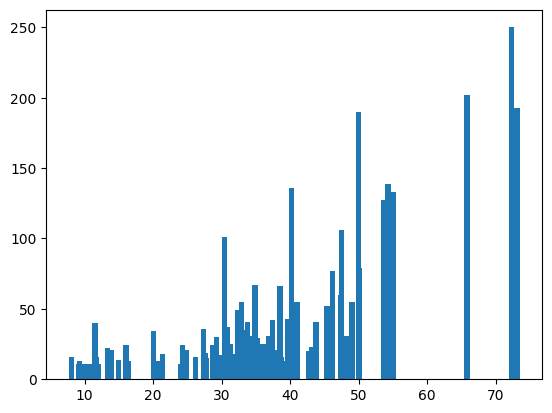

In [ ]:
selected_top_comments_df['rank'] = .5 * selected_top_comments_df.rounds + .5 * selected_top_comments_df.balance
plt.bar(selected_top_comments_df['rank'] * 100, selected_top_comments_df.replies)

Not too bad. Now we can show the top 5 threads as a tree for easy reading:

In [ ]:
def render(xml):
  from IPython.display import HTML
  template = """
  <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.3/dist/js/bootstrap.min.js"></script>
  <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.3/dist/css/bootstrap.min.css">
  %s"""
  return HTML(template % xml)

output = '<ul>'
for id,top_comment in selected_top_comments_df.sort_values(['rank'], ascending=False).iterrows():
  output += f'<li>{top_comment.author}: {top_comment.text} ({top_comment.publishedAt})'
  output += f'<button class="btn btn-primary" data-bs-toggle="collapse" data-bs-target="#thread-{id}"> + </button></li>'
  output += f'<ul class="collapse" id="thread-{id}">'
  for idx, reply in replies_df[replies_df.parent == id].iterrows():
    output += f'<li>{reply.author}: {reply.reply_text} ({reply.publishedAt})</li>'
  output += '</ul>'
output += '</ul>'
render(output)


## Discussions

ChatGPT is pivotal in working out the stance of each reply. How good is it? Let's call the author of each top comment as the OP (Original Poster). If OP replies to his/her own comment, we can assume that reply would be a pros argument at most of the times. In that case, replies of the same OP as the top comment should get a stance of 1. Let's see how many OP replies ChatGPT tags as -1:

In [ ]:
df = selected_top_comments_df[['author']].rename(columns={'author': 'op'})
selected_top_comments_df = pd.merge(replies_df, df, left_on='parent_text', right_index=True)
selected_top_comments_df['reply_to_self'] = selected_top_comments_df.author == selected_top_comments_df.op
selected_top_comments_df[(selected_top_comments_df.reply_to_self) & (selected_top_comments_df.stance == -1)]

,parent,parent_text,replies,author,publishedAt,reply_text,stance,op,reply_to_self
id,,,,,,,,,


Oh well, that's a bit too many 🤷. Anyway, this notebook helps me a lot in finding interesting debates, so I won't complain much.
